<h1>TKN Training Notebook</h1>
This notebook is used to train the network

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
import os, datetime

from matplotlib import pyplot
pyplot.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

<h2>Data Processing</h2>

In [2]:
def get_data():
    time        = np.arange(0, 512, 0.1)
    amplitude = .1 * np.sin(time*.005) +.5 * np.sin(time*.5) + .2 * np.sin(.01) + .001 * np.random.normal(-0.2, 0.2, len(time))
    #amplitude   = np.sin(time*.5) + .2*np.sin(time*.2) + .1 * np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    #amplitude = np.sin(time*0.05) 
    
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    return amplitude

In [3]:
df = get_data()
df = np.array(df).reshape((-1,1))
print(df.shape)

(5120, 1)


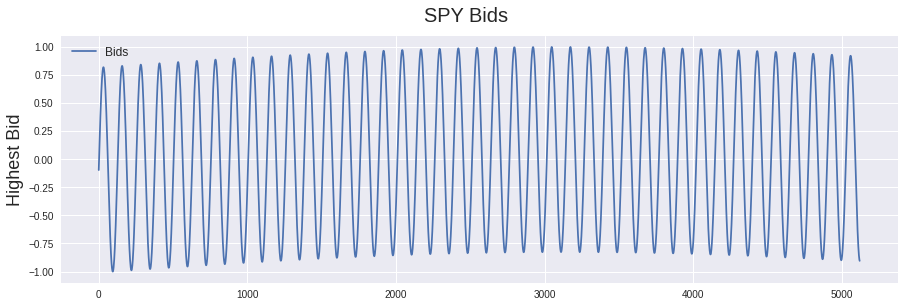

In [4]:
fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df, label='Bids')
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

<h2>Model, Optimizer, and Criterion</h2>

In [5]:
import tkn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using cuda' if torch.cuda.is_available() else 'using cpu')

INPUT_DIM = df.shape[1]

# TODO: AFTER UNCERTAINTY IS IMPLEMENTED, UNCOMMENT
#OUTPUT_DIM = INPUT_DIM * 2
OUTPUT_DIM = INPUT_DIM * 2

# HID_DIM = 256
# ENC_LAYERS = 2
# DEC_LAYERS = 2
# ENC_HEADS = 8
# DEC_HEADS = 8
# ENC_PF_DIM = 512
# DEC_PF_DIM = 512
# ENC_DROPOUT = 0.1
# DEC_DROPOUT = 0.1

# MAX_IN = 128
# MAX_OUT = 128

HID_DIM = 1024
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0
DEC_DROPOUT = 0

PENC_LAYERS_IN = 2
PENC_LAYERS_OUT = 2

MAX_IN = 32
MAX_OUT = 8

enc = tkn.Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device, max_length=MAX_IN,
              penc_layers=PENC_LAYERS_IN)

dec = tkn.Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device, max_length=MAX_OUT,
              penc_layers=PENC_LAYERS_OUT)

using cuda


In [6]:
#TODO: CHANGE PAD value
SRC_PAD = [9 for _ in range(INPUT_DIM)]
TRG_PAD = [9 for _ in range(OUTPUT_DIM)]

SRC_PAD_IDX = torch.FloatTensor(SRC_PAD).to(device)
TRG_PAD_IDX = torch.FloatTensor(OUTPUT_DIM).to(device)

In [7]:
model = tkn.TKN(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 135,467,010 trainable parameters


In [9]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data,gain=.1)
        #torch.nn.init.normal_(m.weight, mean=0.0, std=0.5)
model.apply(initialize_weights);

In [10]:
LEARNING_RATE = 0.00005

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=.7,patience=5,min_lr=1e-7)

# Essentially just a masked MSE Loss
class CustomMSELoss(torch.nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
    
    def forward(self, output, target, do_sigma=False):
        if do_sigma:
            return torch.nn.functional.mse_loss(output, target, reduction='mean')
        else:
            return torch.nn.functional.mse_loss(output[:,:,:INPUT_DIM], target[:,:,:INPUT_DIM], reduction='mean')

criterion = CustomMSELoss()

<h2>Batch Generation</h2>

In [11]:
from random import random

#TODO: generate variable length sequences
def gen_loader(data, batch_size, in_len, out_len, device, prop=.4):
    inps = []
    tgts = []
    
    for i in range(len(data) - in_len - out_len + 1):
        if (random() <= prop):
            inps.append(data[i:i+in_len])
            # TODO: add target uncertainty
            actual_seq = data[i+in_len-1:i+in_len+out_len-1]
            actual_seq = np.concatenate((actual_seq, np.zeros(actual_seq.shape)),1)
            tgts.append(np.concatenate(([TRG_PAD], actual_seq),axis=0))
        
    inps = torch.FloatTensor(inps).to(device)
    tgts = torch.FloatTensor(tgts).to(device)
    
    dataset = torch.utils.data.TensorDataset(inps, tgts)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
def predict_seq(src_tensor, model, device, max_len = MAX_OUT, with_grad=False):
    
    model.eval()
    
    #src_tensor = torch.reshape(src_tensor, (1,src_tensor.shape[0],-1))
    #src_tensor = src_tensor.unsqueeze(0)
    
    src_mask = model.make_src_mask(src_tensor)
    
    if with_grad:
        enc_src = model.encoder(src_tensor, src_mask)
    else:
        with torch.no_grad():
            enc_src = model.encoder(src_tensor, src_mask)

    out_seq = torch.ones((src_tensor.shape[0],1,OUTPUT_DIM), device=device, requires_grad=True) * TRG_PAD[0]
    
    for i in range(max_len):
        trg_mask = model.make_trg_mask(out_seq)
        
        with torch.no_grad():
            output = model.decoder(out_seq, enc_src, trg_mask, src_mask)
        pred = output[:,-1:,:]
        
        out_seq = torch.cat((out_seq, pred), 1)
    
    return out_seq[:,1:,:]

def train(model, loader, optimizer, criterion, clip, prop=0):
    
    model.train()
    
    epoch_loss = 0
    
    total = 0
    
    samples = 0
    
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        
        inp = data[0]
        tgt = data[1]
        
        # TODO: FIX RECURRENT GENERATION
#         if random() > prop:
#             output = model(inp, tgt[:,:-1])
#         else:
#             output = predict_seq(inp, model, device, with_grad=True)

        output = model(inp, tgt[:,:-1])
        
        tgt = tgt[:,1:]
    
#         sq_res = torch.square(tgt[:,:,0:INPUT_DIM] - output[:,:,0:INPUT_DIM]) * .01
        
#         # janky solution to get the index to be an integer
#         tgt[:,:,INPUT_DIM:] = sq_res
# #         tgt = tgt[:,1:].contiguous().view(-1)
    
        loss = criterion(output, tgt, do_sigma=False)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        total = i
        
        samples += inp.shape[0]
        
    return epoch_loss / (total+1), samples



def evaluate(model, loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    total = 0
    
    samples = 0
    
    with torch.no_grad():
    
        for i, data in enumerate(loader):
            inp = data[0]
            tgt = data[1]
            
            output = model(inp, tgt[:,:-1])

    #         output = output.contiguous().view(-1, OUTPUT_DIM)
            tgt = tgt[:,1:]

#             sq_res = torch.square(tgt[:,:,0:INPUT_DIM] -  output[:,:,0:INPUT_DIM]) * .01

#             # janky solution to get thue index to be an integer
#             tgt[:,:,INPUT_DIM:] = sq_res
#     #         tgt = tgt[:,1:].contiguous().view(-1)
    
            loss = criterion(output, tgt, do_sigma=False)

            epoch_loss += loss.item()
            
            total = i
            
            samples += inp.shape[0]
        
    return epoch_loss / (total+1), samples

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
TRAIN_RATIO = .8
BATCH_SIZE = 64

T_INDEX = math.ceil(TRAIN_RATIO * len(df))

tdf = df[:T_INDEX]
vdf = df[T_INDEX:]

train_iterator = gen_loader(tdf, BATCH_SIZE, MAX_IN, MAX_OUT, device, prop=.1)
valid_iterator = gen_loader(vdf, vdf.shape[0], MAX_IN, MAX_OUT, device, prop=.1)

In [15]:
PRELOAD = False

if PRELOAD:
    model.load_state_dict(torch.load('tkn-model.pt'))

In [16]:
N_EPOCHS = 16000
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_samples = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss, valid_samples = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:        
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'tkn-model.pt')
    
    temp_lr = [ group['lr'] for group in optimizer.param_groups]
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | lr: {temp_lr[0]:.8f}')
    
    print(f'\tTrain Loss: {train_loss:.5f} | Train Samples: {train_samples}')
    print(f'\t Val. Loss: {valid_loss:.5f} | Val. Samples: {valid_samples}')
    
    scheduler.step(valid_loss)

Epoch: 01 | Time: 0m 1s | lr: 0.00005000
	Train Loss: 0.40645 | Train Samples: 380
	 Val. Loss: 0.45797 | Val. Samples: 100
Epoch: 02 | Time: 0m 1s | lr: 0.00005000
	Train Loss: 0.40651 | Train Samples: 380
	 Val. Loss: 0.45762 | Val. Samples: 100
Epoch: 03 | Time: 0m 1s | lr: 0.00005000
	Train Loss: 0.40526 | Train Samples: 380
	 Val. Loss: 0.45744 | Val. Samples: 100
Epoch: 04 | Time: 0m 1s | lr: 0.00005000
	Train Loss: 0.40310 | Train Samples: 380
	 Val. Loss: 0.45796 | Val. Samples: 100
Epoch: 05 | Time: 0m 1s | lr: 0.00005000
	Train Loss: 0.40242 | Train Samples: 380
	 Val. Loss: 0.45943 | Val. Samples: 100
Epoch: 06 | Time: 0m 1s | lr: 0.00005000
	Train Loss: 0.40285 | Train Samples: 380
	 Val. Loss: 0.45958 | Val. Samples: 100
Epoch: 07 | Time: 0m 1s | lr: 0.00005000
	Train Loss: 0.40252 | Train Samples: 380
	 Val. Loss: 0.45930 | Val. Samples: 100
Epoch: 08 | Time: 0m 1s | lr: 0.00005000
	Train Loss: 0.40304 | Train Samples: 380
	 Val. Loss: 0.45803 | Val. Samples: 100
Epoch: 0

Epoch: 68 | Time: 0m 1s | lr: 0.00001200
	Train Loss: 0.05174 | Train Samples: 380
	 Val. Loss: 0.05932 | Val. Samples: 100
Epoch: 69 | Time: 0m 1s | lr: 0.00001200
	Train Loss: 0.05135 | Train Samples: 380
	 Val. Loss: 0.05940 | Val. Samples: 100
Epoch: 70 | Time: 0m 1s | lr: 0.00001200
	Train Loss: 0.05183 | Train Samples: 380
	 Val. Loss: 0.06010 | Val. Samples: 100
Epoch: 71 | Time: 0m 1s | lr: 0.00001200
	Train Loss: 0.05138 | Train Samples: 380
	 Val. Loss: 0.05904 | Val. Samples: 100
Epoch: 72 | Time: 0m 1s | lr: 0.00000840
	Train Loss: 0.05161 | Train Samples: 380
	 Val. Loss: 0.06014 | Val. Samples: 100
Epoch: 73 | Time: 0m 1s | lr: 0.00000840
	Train Loss: 0.05162 | Train Samples: 380
	 Val. Loss: 0.05858 | Val. Samples: 100
Epoch: 74 | Time: 0m 1s | lr: 0.00000840
	Train Loss: 0.05101 | Train Samples: 380
	 Val. Loss: 0.05863 | Val. Samples: 100
Epoch: 75 | Time: 0m 1s | lr: 0.00000840
	Train Loss: 0.05105 | Train Samples: 380
	 Val. Loss: 0.05858 | Val. Samples: 100
Epoch: 7

KeyboardInterrupt: 

In [33]:
torch.save(model.state_dict(), 'tkn-model.pt')

model.load_state_dict(torch.load('tkn-model.pt'))

# TODO: change valid to test iterator
test_loss, samples = evaluate(model, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.059 | Test PPL:   1.060 |


In [ ]:
# TODO: display attention

In [17]:
def ex_evaluate(model, loader, criterion):
    model.train()
    
    epoch_loss = 0
    
    total = 0
    
    samples = 0
    
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        
        inp = data[0]
        tgt = data[1]
        
        # TODO: FIX RECURRENT GENERATION
#         if random() > prop:
#             output = model(inp, tgt[:,:-1])
#         else:
#             output = predict_seq(inp, model, device, with_grad=True)

        output = model(inp, tgt[:,:-1])
        
        tgt = tgt[:,1:]
    
        sq_res = torch.square(tgt[:,:,0:INPUT_DIM] - output[:,:,0:INPUT_DIM]) * .01
        
        # janky solution to get thue index to be an integer
        tgt[:,:,INPUT_DIM:] = sq_res
#         tgt = tgt[:,1:].contiguous().view(-1)

        loss = criterion(output, tgt, do_sigma=False)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        total = i
        
        samples += inp.shape[0]
        
        return inp, tgt, output

[[-0.82025576]
 [-0.8248682 ]
 [-0.82714856]
 [-0.8273774 ]
 [-0.8246633 ]
 [-0.82016885]
 [-0.8138647 ]
 [-0.8041085 ]
 [-0.7934791 ]
 [-0.7795493 ]
 [-0.7647505 ]
 [-0.7459501 ]
 [-0.726674  ]
 [-0.7046124 ]
 [-0.68071836]
 [-0.65449953]
 [-0.6278382 ]
 [-0.59794223]
 [-0.5668739 ]
 [-0.53408796]
 [-0.49967316]
 [-0.46448264]
 [-0.426699  ]
 [-0.38900152]
 [-0.3489476 ]
 [-0.30866534]
 [-0.26630336]
 [-0.22451733]
 [-0.18150176]
 [-0.1376356 ]
 [-0.09213512]
 [-0.04681867]
 [-0.04681867]
 [-0.00225585]
 [ 0.0431721 ]
 [ 0.08909197]
 [ 0.13448921]
 [ 0.18074666]
 [ 0.22486083]
 [ 0.26965496]]
[[ 0.04926114 -0.02974124]
 [-0.05574433 -0.02894053]
 [-0.00742919 -0.02937507]
 [ 0.0411918  -0.02906494]
 [ 0.08923291 -0.02842147]
 [ 0.13425308 -0.02763129]
 [ 0.17825444 -0.02662291]
 [ 0.22024433 -0.02559533]]
[[-4.6818670e-02  9.2313298e-05]
 [-2.2558451e-03  2.8610175e-05]
 [ 4.3172099e-02  2.5604906e-05]
 [ 8.9091972e-02  2.2944263e-05]
 [ 1.3448921e-01  2.0481322e-05]
 [ 1.8074666e-01 

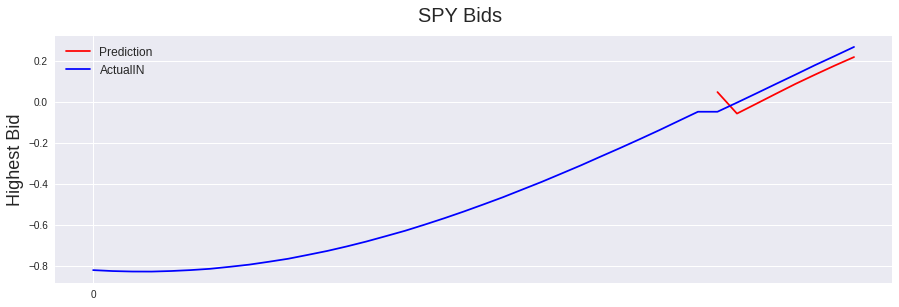

In [32]:
ex_inp, ex_tgt, ex_output = ex_evaluate(model, train_iterator, criterion)

# print(ex_inp[0])
# print(ex_tgt[0])
# print(ex_output[0])

ex_seq = np.concatenate((ex_inp[0].detach().cpu().numpy(), ex_tgt[0].detach().cpu().numpy()[:,0:1]), 0)
pred = ex_output[0].detach().cpu().numpy()
actual = ex_tgt[0].detach().cpu().numpy()

print(ex_seq)
print(pred)
print(actual)

fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)
ax1 = fig.add_subplot(211)

ax1.plot(np.arange(MAX_IN, MAX_IN+pred.shape[0]),pred[:,0], color='red', label='Prediction')
ax1.plot(np.arange(0, ex_seq.shape[0]),ex_seq[:,0], color='blue', label='ActualIN')
ax1.set_xticks(range(0, pred.shape[0], 1464))
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

In [ ]:
start = math.floor(random() * (len(df) - MAX_IN - MAX_OUT))

ex_seq = df[start:start+(MAX_IN+MAX_OUT)]

ex_inps = torch.FloatTensor([ex_seq[:MAX_IN]]).to(device)


pred = predict_seq(ex_inps, model, device)

pred = pred[0].detach().cpu().numpy()

print(f'predicted trg = {pred}')

fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)
ax1 = fig.add_subplot(211)
ax1.plot(np.arange(MAX_IN, ex_seq.shape[0]),pred[:,0], color='red', label='Prediction')
ax1.plot(np.arange(0, ex_seq.shape[0]),ex_seq[:,0], color='blue', label='Actual')
ax1.set_xticks(range(0, pred.shape[0], 1464))
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

In [ ]:
start = math.floor(random() * (len(df) - MAX_IN - MAX_OUT))

ex_seq = df[start:start+(MAX_IN+MAX_OUT)]

ex_inp = torch.FloatTensor([ex_seq[:MAX_IN]]).to(device)

tgts = []

actual_seq = ex_seq[MAX_IN:]
actual_seq = np.concatenate((actual_seq, np.zeros(actual_seq.shape)),1)
tgts.append(np.concatenate(([TRG_PAD], actual_seq),axis=0))
        
ex_tgt = torch.FloatTensor(tgts).to(device)

pred = model(ex_inp, ex_tgt[:,:-1])
pred = pred[0].detach().cpu().numpy()
ex_tgt = ex_tgt[0,1:].detach().cpu().numpy()

print(f'predicted trg = {pred}')
print(ex_tgt)

fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)
ax1 = fig.add_subplot(211)
ax1.plot(np.arange(MAX_IN, ex_seq.shape[0]),pred[:,0], color='red', label='Prediction')
ax1.plot(np.arange(MAX_IN, ex_seq.shape[0]),ex_tgt[:,0], color='green', label='Actual Out')
ax1.plot(np.arange(0, ex_seq.shape[0]),ex_seq[:,0], color='blue', label='Actual')
ax1.set_xticks(range(0, pred.shape[0], 1464))
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)